#  AI Demand Forecasting & Dynamic Replenishment Agent
## Production-Ready ML System for Inventory Optimization

This notebook demonstrates a complete AI agent for demand forecasting using Qwen2.5 models.

**Key Features:**
- Continuous learning from historical sales data
- Multi-factor analysis (seasonality, trends, external factors)
- Dynamic reorder point calculation
- Interactive web dashboard
- AI-powered insights using Qwen2.5-7B-Instruct

**Learning Objectives:**
- Generate synthetic sales data with realistic patterns
- Engineer features for time series forecasting
- Train gradient boosting models for demand prediction
- Calculate dynamic reorder recommendations
- Deploy interactive dashboard for business users

In [1]:
# %% Setup
import sys
sys.path.insert(0, '..')

from src.data_generator import SalesDataGenerator
from src.forecasting_agent import DemandForecastingAgent
from src.model_loader import ModelLoader
from src.dashboard import ForecastingDashboard

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)
%matplotlib inline

print(" Imports successful!")
print(f" Pandas: {pd.__version__}")
print(f" NumPy: {np.__version__}")

 Imports successful!
 Pandas: 2.3.3
 NumPy: 2.2.5


In [2]:
# %% Generate Synthetic Sales Data
# Generate 2 years of sales data with realistic patterns:
# - Trends, seasonality, weekly patterns
# - Holiday effects
# - Random variations and stockouts

# Initialize data generator
generator = SalesDataGenerator(seed=42)

print(" Generating synthetic sales data...")
sales_df = generator.generate_sales_data(
    start_date='2022-01-01',
    periods=730,  # 2 years
    n_skus=10     # 10 products
)

# Generate external factors
print("  Generating external factors...")
external_df = generator.generate_external_factors(sales_df)

# Generate inventory status
print(" Generating inventory data...")
inventory_df = generator.generate_inventory_data(sales_df)

print(f"\n Generated {len(sales_df):,} sales records")
print(f" SKUs: {sales_df['sku_id'].nunique()}")
print(f" Date range: {sales_df['date'].min()} to {sales_df['date'].max()}")

display(sales_df.head())

 Generating synthetic sales data...
  Generating external factors...
 Generating inventory data...

 Generated 7,300 sales records
 SKUs: 10
 Date range: 2022-01-01 00:00:00 to 2023-12-31 00:00:00


,date,sku_id,category,sales,stockout,price,cost
0,2022-01-01,SKU_001,Home,202,False,24.04,7.61
1,2022-01-02,SKU_001,Home,216,False,64.10,36.86
2,2022-01-03,SKU_001,Home,187,False,26.51,18.69
3,2022-01-04,SKU_001,Home,203,False,48.88,18.11
4,2022-01-05,SKU_001,Home,180,False,42.97,25.52


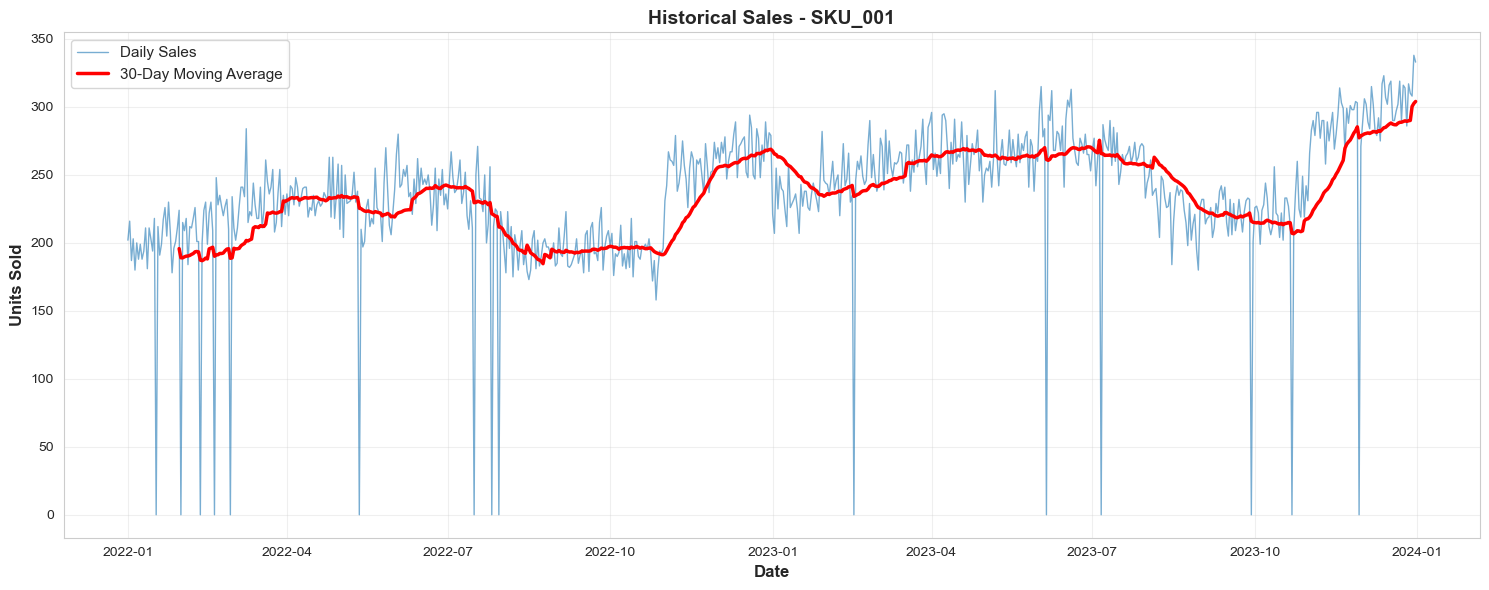

 Historical sales visualization complete!


In [3]:
# %% Visualize Historical Sales Data
# Plot sales trends for first SKU with moving averages

# Plot sales for first SKU
sku = 'SKU_001'
sku_data = sales_df[sales_df['sku_id'] == sku].copy()
sku_data['date'] = pd.to_datetime(sku_data['date'])

plt.figure(figsize=(15, 6))
plt.plot(sku_data['date'], sku_data['sales'], alpha=0.6, label='Daily Sales', linewidth=1)
plt.plot(sku_data['date'], sku_data['sales'].rolling(30).mean(), 
         color='red', linewidth=2.5, label='30-Day Moving Average')
plt.title(f'Historical Sales - {sku}', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Units Sold', fontsize=12, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(" Historical sales visualization complete!")

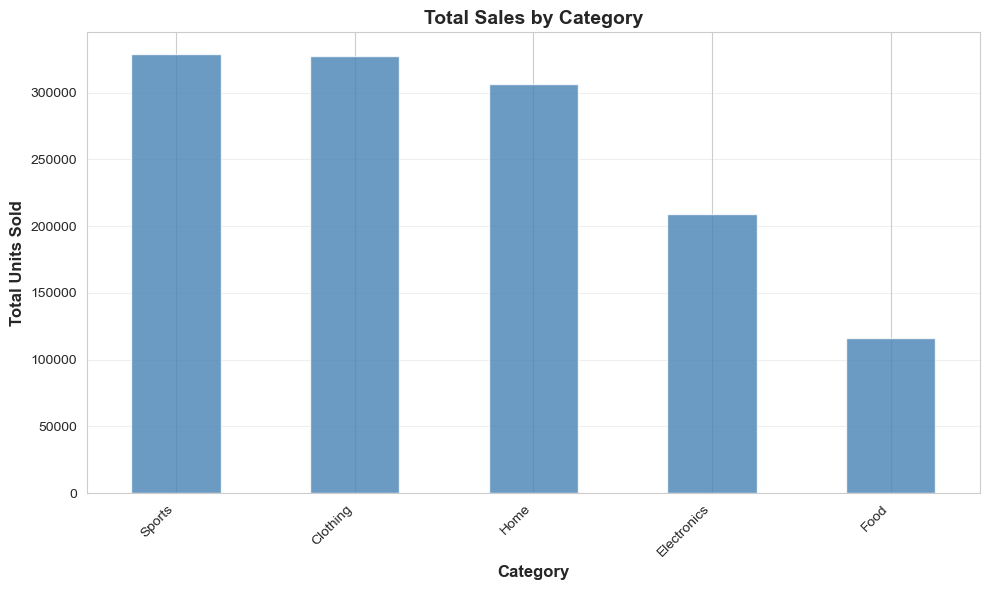


 Category Summary:
category
Sports         328641
Clothing       327358
Home           306424
Electronics    209030
Food           115833
Name: sales, dtype: int64

 Category analysis complete!


In [4]:
# %% Category Distribution Analysis
# Analyze sales distribution across product categories

# Category sales breakdown
category_sales = sales_df.groupby('category')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
category_sales.plot(kind='bar', color='steelblue', alpha=0.8)
plt.title('Total Sales by Category', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12, fontweight='bold')
plt.ylabel('Total Units Sold', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Category Summary:")
print(category_sales)
print("\n Category analysis complete!")

In [5]:
# %% Initialize Forecasting Agent
# Create AI agent with machine learning capabilities

agent = DemandForecastingAgent()
print(" Demand Forecasting Agent initialized")
print("\n Agent Capabilities:")
print("   • Feature engineering (lag, rolling statistics)")
print("   • Gradient Boosting Regressor")
print("   • Continuous learning from new data")
print("   • Dynamic reorder calculations")
print("   • Forecast accuracy tracking (MAPE, R²)")

 Demand Forecasting Agent initialized

 Agent Capabilities:
   • Feature engineering (lag, rolling statistics)
   • Gradient Boosting Regressor
   • Continuous learning from new data
   • Dynamic reorder calculations
   • Forecast accuracy tracking (MAPE, R²)


In [6]:
# %% Train Forecasting Models
# Train ML models for first 3 SKUs
# Models learn patterns from historical data

skus = sales_df['sku_id'].unique()[:3]

print(" Training forecasting models...\n")
for i, sku in enumerate(skus, 1):
    print(f"[{i}/{len(skus)}] Training model for {sku}...", end=" ")
    model, metrics = agent.train_model(sku, sales_df, external_df)
    print(f" MAPE: {metrics['mape']:.2f}%, R²: {metrics['test_score']:.2%}")

print("\n Model training complete!")

# Show model performance
performance_df = agent.get_model_performance()
print("\n Model Performance Summary:\n")
display(performance_df)

 Training forecasting models...

[1/3] Training model for SKU_001...  MAPE: 497.47%, R²: 35.90%
[2/3] Training model for SKU_002...  MAPE: 87.70%, R²: 79.88%
[3/3] Training model for SKU_003...  MAPE: 328.05%, R²: 49.11%

 Model training complete!

 Model Performance Summary:



,train_score,test_score,mape
SKU_001,0.983776,0.359013,497.470716
SKU_002,0.975029,0.798755,87.703337
SKU_003,0.983211,0.491133,328.048887


In [7]:
# %% Generate 30-Day Forecast
# Generate demand predictions for next 30 days
# Includes confidence intervals for uncertainty quantification

sku = 'SKU_001'
future_dates = pd.date_range(start=pd.Timestamp.now(), periods=30, freq='D')

print(f" Generating 30-day forecast for {sku}...")
forecast_df = agent.predict_demand(sku, future_dates, external_df)

print("\n Forecast generated successfully!")
print(f"   Avg daily demand: {forecast_df['predicted_demand'].mean():.1f} units")
print(f"   Peak demand: {forecast_df['predicted_demand'].max()} units")
print(f"   Total 30-day demand: {forecast_df['predicted_demand'].sum():,} units")

print("\n Forecast Summary (First 10 Days):\n")
display(forecast_df.head(10))

 Generating 30-day forecast for SKU_001...

 Forecast generated successfully!
   Avg daily demand: 1.3 units
   Peak demand: 11 units
   Total 30-day demand: 40 units

 Forecast Summary (First 10 Days):



,date,sku_id,predicted_demand,lower_bound,upper_bound,confidence
0,2025-11-21 20:51:41.286649,SKU_001,0,74,0,95
1,2025-11-22 20:51:41.286649,SKU_001,0,117,0,95
2,2025-11-23 20:51:41.286649,SKU_001,0,94,0,95
3,2025-11-24 20:51:41.286649,SKU_001,0,49,0,95
4,2025-11-25 20:51:41.286649,SKU_001,0,48,0,95
5,2025-11-26 20:51:41.286649,SKU_001,6,0,70,95
6,2025-11-27 20:51:41.286649,SKU_001,8,0,95,95
7,2025-11-28 20:51:41.286649,SKU_001,9,0,102,95
8,2025-11-29 20:51:41.286649,SKU_001,6,0,73,95
9,2025-11-30 20:51:41.286649,SKU_001,11,0,120,95


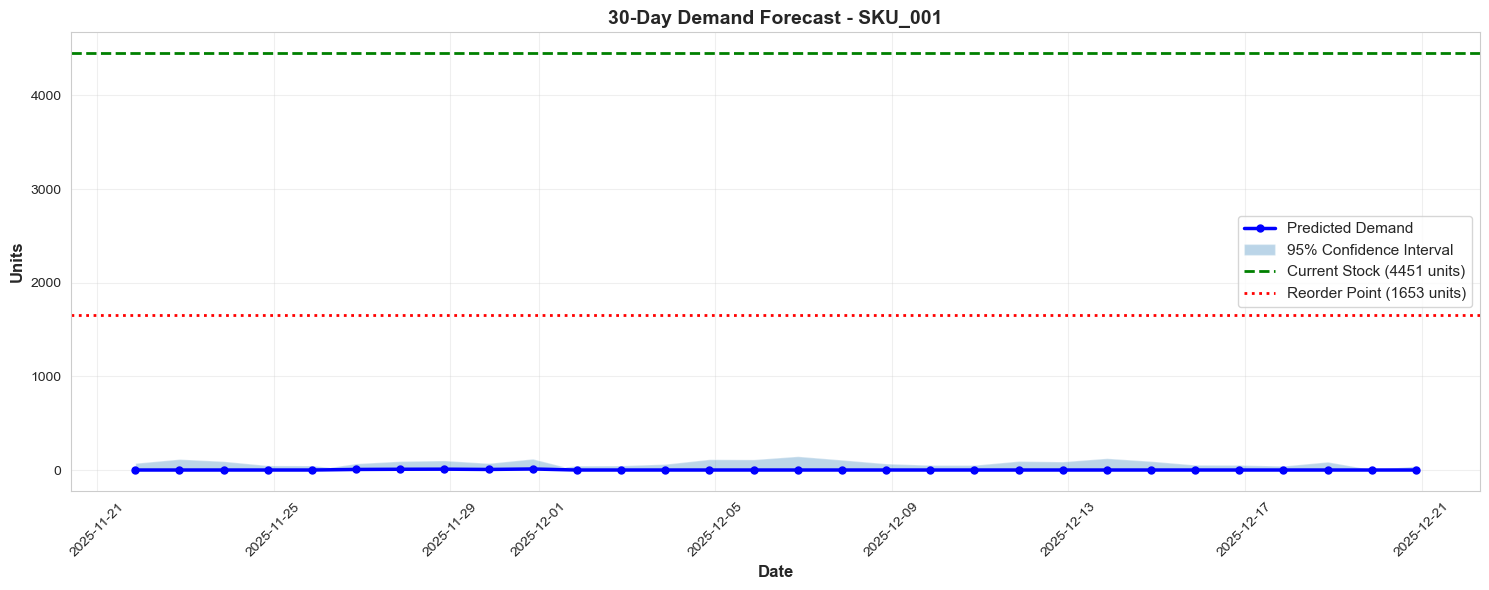

 Forecast visualization complete!


In [8]:
# %% Visualize Forecast with Inventory Levels
# Plot forecast with confidence intervals and inventory thresholds

plt.figure(figsize=(15, 6))

# Plot forecast
plt.plot(forecast_df['date'], forecast_df['predicted_demand'], 
         'b-', linewidth=2.5, label='Predicted Demand', marker='o', markersize=5)

# Confidence interval
plt.fill_between(forecast_df['date'], 
                  forecast_df['lower_bound'], 
                  forecast_df['upper_bound'],
                  alpha=0.3, label='95% Confidence Interval')

# Inventory levels
inv_info = inventory_df[inventory_df['sku_id'] == sku].iloc[0]
plt.axhline(y=inv_info['current_stock'], color='green', 
            linestyle='--', linewidth=2, label=f"Current Stock ({inv_info['current_stock']} units)")
plt.axhline(y=inv_info['reorder_point'], color='red', 
            linestyle=':', linewidth=2, label=f"Reorder Point ({inv_info['reorder_point']} units)")

plt.title(f'30-Day Demand Forecast - {sku}', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Units', fontsize=12, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(" Forecast visualization complete!")

In [9]:
# %% Calculate Dynamic Reorder Recommendation
# Calculate optimal reorder point and quantity
# Based on forecast, lead time, and safety stock

reorder_info = agent.calculate_dynamic_reorder(
    sku,
    forecast_df,
    inv_info['current_stock'],
    inv_info['lead_time_days']
)

print(f"\n{'='*60}")
print(f" REORDER RECOMMENDATION - {sku}")
print(f"{'='*60}")

print(f"\n CURRENT STATUS:")
print(f"   Current Stock: {reorder_info['current_stock']:,} units")
print(f"   Reorder Point: {reorder_info['reorder_point']:,} units")
print(f"   Safety Stock: {reorder_info['safety_stock']:,} units")
print(f"   Lead Time: {inv_info['lead_time_days']} days")

print(f"\n FORECAST INSIGHTS:")
print(f"   Expected Lead Time Demand: {reorder_info['lead_time_demand']:,} units")
print(f"   Days Until Stockout: {reorder_info['days_until_stockout']} days")
print(f"   Forecast Avg Daily Demand: {forecast_df['predicted_demand'].mean():.1f} units")

print(f"\n RECOMMENDATION:")
print(f"   Needs Reorder: {'YES ⚠️' if reorder_info['needs_reorder'] else 'NO ✓'}")
print(f"   Urgency Level: {reorder_info['urgency']}")
print(f"   Recommended Order Quantity: {reorder_info['reorder_quantity']:,} units")

if reorder_info['needs_reorder']:
    print(f"\n    ACTION REQUIRED: Place order immediately to avoid stockout!")

print(f"\n{'='*60}\n")


 REORDER RECOMMENDATION - SKU_001

 CURRENT STATUS:
   Current Stock: 4,451 units
   Reorder Point: 120 units
   Safety Stock: 80 units
   Lead Time: 12 days

 FORECAST INSIGHTS:
   Expected Lead Time Demand: 40 units
   Days Until Stockout: 30 days
   Forecast Avg Daily Demand: 1.3 units

 RECOMMENDATION:
   Needs Reorder: NO ✓
   Urgency Level: LOW
   Recommended Order Quantity: 32 units




In [10]:
# %% Optional: AI-Powered Analysis with Qwen2.5
# OPTIONAL: Generate AI insights using Qwen2.5 model
# Skip this cell if you don't have a local model or want to avoid downloading
#
# Requirements:
# - Local model running at http://127.0.0.1:8080, OR
# - ~5GB disk space and 8GB+ RAM to download model

# Option 1: Use LOCAL model (recommended)
model_loader = ModelLoader(
    model_name='qwen2.5-7b',
    use_local=True,
    local_endpoint='http://127.0.0.1:8080'
)
model_loader.load_model()

# Option 2: Download model (uncomment if you want to download)
# model_loader = ModelLoader(model_name='qwen2.5-7b', device='cpu')
# model_loader.load_model()

# Prepare analysis data
sku_history = sales_df[sales_df['sku_id'] == sku].tail(90)
historical_data = {
    'avg_sales': sku_history['sales'].mean(),
    'trend': 'increasing' if sku_history['sales'].iloc[-1] > sku_history['sales'].iloc[0] else 'decreasing',
    'seasonality': 'moderate',
    'stockout_rate': (sales_df['stockout'].sum() / len(sales_df)) * 100,
    'current_stock': inv_info['current_stock'],
    'reorder_point': inv_info['reorder_point'],
    'lead_time': inv_info['lead_time_days']
}

forecast_data = {
    'predicted_avg': forecast_df['predicted_demand'].mean(),
    'peak_demand': forecast_df['predicted_demand'].max(),
    'peak_day': forecast_df['predicted_demand'].idxmax() + 1,
    'confidence': 95
}

external_factors = {
    'economic_index': external_df['economic_index'].mean() if 'economic_index' in external_df.columns else 100,
    'seasonal': 'current',
    'promotion': 'active' if external_df['promotion_active'].sum() > 0 else 'none'
}

# Generate AI analysis
print(" Generating AI-powered analysis...\n")
print("This may take 10-30 seconds depending on your setup...\n")

try:
    analysis = model_loader.analyze_forecast(
        historical_data,
        forecast_data,
        external_factors
    )
    
    print("="*70)
    print(" AI ANALYSIS")
    print("="*70)
    print(analysis)
    print("="*70)
    
    print("\n AI analysis complete!")
    
except Exception as e:
    print(f" AI analysis failed: {e}")
    print("Continuing without AI insights...")

 Using local model at http://127.0.0.1:8080
  No model download required - using local inference server
 Local model server is responsive
 Generating AI-powered analysis...

This may take 10-30 seconds depending on your setup...

 AI ANALYSIS
.

. **Risk Assessment:**
   - **Stockout Risk:** The stockout rate is 2.04%, which is relatively low but still indicates some risk. The predicted average daily sales for the next 30 days is significantly lower than the historical average (1.33 vs 267.46), which could increase the stockout risk if the sales trend continues.
   - **Overstock Risk:** The current inventory level is 4451 units, which is above the reorder point (1653 units). Given the low predicted average daily sales, there is a risk of overstock if the sales trend does not improve.

2. **Recommended Actions:**
   - **Reorder Quantity:** Given the low predicted average daily sales and the current inventory level, consider ordering a lower quantity than the historical reorder point. A 

In [11]:
# %% Launch Interactive Dashboard
# Start web-based dashboard for interactive analysis
# Access at http://127.0.0.1:8050
#
# Features:
# - SKU selection dropdown
# - Adjustable forecast horizon (7-90 days)
# - Real-time visualizations
# - Reorder recommendations
# - Model performance metrics

dashboard = ForecastingDashboard(agent, sales_df, external_df, inventory_df)

print("\n" + "="*70)
print(" LAUNCHING INTERACTIVE DASHBOARD")
print("="*70)
print("\n URL: http://127.0.0.1:8050")
print("\n Dashboard Features:")
print("   • Select SKU and forecast horizon")
print("   • View demand predictions with confidence intervals")
print("   • Get dynamic reorder recommendations")
print("   • Analyze historical sales patterns")
print("   • Track model performance metrics")
print("   • Generate AI-powered insights")
print("\n  Note: Dashboard runs in blocking mode")
print("   Press Ctrl+C in terminal to stop the server")
print("="*70 + "\n")

dashboard.run(host='127.0.0.1', port=8050, debug=True)


 LAUNCHING INTERACTIVE DASHBOARD

 URL: http://127.0.0.1:8050

 Dashboard Features:
   • Select SKU and forecast horizon
   • View demand predictions with confidence intervals
   • Get dynamic reorder recommendations
   • Analyze historical sales patterns
   • Track model performance metrics
   • Generate AI-powered insights

  Note: Dashboard runs in blocking mode
   Press Ctrl+C in terminal to stop the server


🚀 LAUNCHING AI DEMAND FORECASTING DASHBOARD

📊 Dashboard URL: http://127.0.0.1:8050

✨ Features:
   • Comprehensive demand forecasting with ML
   • Dynamic reorder recommendations
   • Historical trend analysis
   • Seasonality and weekly patterns
   • Risk assessment dashboard
   • AI-powered insights
   • Real-time interactive visualizations

⚠️  Press Ctrl+C to stop the server



Address already in use
Port 8050 is in use by another program. Either identify and stop that program, or start the server with a different port.


SystemExit: 1

In [ ]:
# %% Save Results
# Export data and forecasts to CSV files

print(" Saving data files...")

sales_df.to_csv('../data/sales_data.csv', index=False)
external_df.to_csv('../data/external_factors.csv', index=False)
inventory_df.to_csv('../data/inventory_status.csv', index=False)
forecast_df.to_csv('../data/forecast_results.csv', index=False)

print("\n Files saved successfully:")
print("   • data/sales_data.csv")
print("   • data/external_factors.csv")
print("   • data/inventory_status.csv")
print("   • data/forecast_results.csv")

print("\n Analysis complete!")